<a href="https://colab.research.google.com/github/adenilso/sucupira-indicadores/blob/master/Sucupira_Indicadores_Quadrienal_2017_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Código para geração dos gráficos

##Setup

In [1]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import io
from plotnine import *
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from collections import Counter

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
estratos = ["A1", "A2", "A3", "A4", "B1", "B2", "B3", "B4"]
estratos.reverse()

In [3]:
pesos = dict({"B4": 0.05,
               "B3": 0.10,
               "B2": 0.20,
               "B1": 0.50,
               "A4": 0.625,
               "A3": 0.75, 
               "A2": 0.875,
               "A1": 1.0,
               "C": 0
              })

In [4]:
def carregar_planilhas(sheetnames):
  path = '/content/drive/My Drive/CAPES2018-2021/Quadrienal 2017-2020/Indicadores/'
  sheets = dict([[sn, pd.read_csv(path + 'CC-' + sn + '.csv', delimiter="\t",error_bad_lines=False)] for sn in sheetnames])
  return sheets

In [5]:
sheetnames = ['producoes_lista', 'programas', 'docentes', 'discentes', 'TCC'] 
sheets = carregar_planilhas(sheetnames)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DtypeWarning: Columns (6,13,75) have mixed types.Specify dtype option on import or set low_memory=False.
  This is separate from the ipykernel package so we can avoid doing imports until
b'Skipping line 24408: expected 49 fields, saw 61\nSkipping line 24915: expected 49 fields, saw 61\n'
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DtypeWarning: Columns (6,31) have mixed types.Specify dtype option on import or set low_memory=False.
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:

producoes = sheets['producoes_lista']
docentes = sheets['docentes']
programas = sheets['programas']
campos = ["Cod PPG", "Sigla", "Nome PPG", "Modalidade", "Ano Início Nível", "Nível"]
siglas = programas \
  .rename(columns={"IES Principal Sigla": "Sigla"}) \
  .groupby(campos) \
  .size() \
  .reset_index() \
  [campos]
notas = programas[["Cod PPG", "Nota"]]
notas["Nota"] = notas["Nota"].apply(lambda x: str(x))
siglas = pd.merge(siglas[campos], notas, on="Cod PPG")
siglas['NotaStr'] = siglas['Nota'].apply(lambda x: str(x))
siglas['Modalidade'] = siglas['Modalidade'].apply(lambda x: x[0])
siglas['Ano Início Nível'] = siglas['Ano Início Nível'].apply(lambda x: x[0:4])
niveismap = dict({
    "MESTRADO": "M",
    "MESTRADO/DOUTORADO": "MD",
    "MESTRADO PROFISSIONAL": "M",
    "MESTRADO PROFISSIONAL/DOUTORADO PROFISSIONAL": "MD",
    "DOUTORADO": "D"
  })
for key, value in niveismap.items():
  siglas.loc[siglas['Nível'] == key, ['Nível']] = value

siglas['Acronym'] = siglas['Nome PPG'] \
  .apply(lambda x: ''.join(map(lambda s: s[0], filter(lambda s: len(s) > 5, x.split(' ')))))
siglas['SiglaTmp'] = siglas['Sigla'] +  \
  '-' + siglas['Acronym'] + \
  '-' + siglas['NotaStr'] + \
  ' (' + siglas['Nível'] + '-' + siglas['Modalidade'] + '-' + siglas['Ano Início Nível'] + ')'
siglas['Sigla'] = siglas['SiglaTmp']
siglas=siglas.drop(columns=['Nome PPG', 'Nota', 'NotaStr', 'Acronym', 'SiglaTmp', 'Modalidade', 'Ano Início Nível', 'Nível'])
siglas=siglas.groupby(['Cod PPG', 'Sigla']).sum().reset_index()
anos=programas[['Cod PPG', 'Ano Base']].groupby(['Cod PPG']).size().reset_index().rename(columns={0: 'QteAnos'})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Funcões de Sumarização

In [7]:
def sumarizar_docs(docs):
  res = pd.DataFrame({"Cod PPG": list(set(docs["Cod PPG"].values))})
  for tipo in ["PERMANENTE", "COLABORADOR"]: 
    p = docs.loc[
              docs["Categoria"] == tipo,
            ["Cod PPG", "Categoria"]
    ].groupby(by=["Cod PPG"]).count().rename(columns={"Categoria": tipo})
    #p.loc[p[tipo].isnull()]
    res = pd.merge(res, p, on="Cod PPG", how="left")
  for tipo in ["PERMANENTE", "COLABORADOR"]:
    res.loc[res[tipo].isnull(), [tipo]] = 0
  return res

In [8]:
sumario_docentes = sumarizar_docs(docentes.loc[docentes["Modalidade"] == "ACADÊMICO"])

In [9]:
def sumarizar_prod(prod):
  res = pd.DataFrame({"Cod PPG": list(set(prod["Cod PPG"].values))})
  for estrato in estratos: 
    p = prod.loc[
              (prod["Natureza"] == "TRABALHO COMPLETO") &
              (prod["Estrato"] == estrato), 
            ["Cod PPG", "Estrato"]
    ].groupby(by=["Cod PPG"]).count()
    res = pd.merge(res, p, on="Cod PPG", how="left").rename(columns={"Estrato": estrato})
  return res

In [71]:
sumario_prod = sumarizar_prod(producoes.loc[
                                            (producoes["Subtipo"].isin(["ARTIGO EM PERIÓDICO", "TRABALHO EM ANAIS"]))
                                            ])

In [72]:
def sumarizar_TCC(tcc):
  res = pd.DataFrame({"Cod PPG": list(set(tcc["Cod PPG"].values))})
  for tipo in ["DISSERTAÇÃO", "TESE"]: 
    p = tcc.loc[
              (tcc["Subtipo"] == tipo), 
            ["Cod PPG", "Subtipo"]
    ].groupby(by=["Cod PPG"]).count()
    res = pd.merge(res, p, on="Cod PPG", how="left").rename(columns={"Subtipo": tipo})
  return res

In [73]:
def ponderar_por_docs(data, docs, campos):
  res = pd.merge(data, docs, on=["Cod PPG"], how="left")
  res = res.loc[res["PERMANENTE"] + res["COLABORADOR"] > 0]
  for campo in campos:
    res.loc[:, [campo]] = res[campo] / (res["PERMANENTE"] + res["COLABORADOR"])
  return res

In [74]:
def ponderar_por_ano(data, anos, campos):
  res = pd.merge(data, anos, on=["Cod PPG"], how="left")
  for campo in campos:
    res.loc[:, [campo]] = res[campo] / (res["QteAnos"])
  return res

In [75]:
sumario_TCC = sumarizar_TCC(sheets["TCC"])

In [76]:
def processar_autores(autores):
  res = []
  for i, autor in enumerate(autores):
    found = re.search('(.*) \((.*)\)', autor)
    if found:
      res.append([i, found.group(1), found.group(2)])
  return res

In [77]:
def sumarizar_autores(prod):
  fields = ['Cod PPG', 'Estrato', 'ID_ADD_PRODUCAO_INTELECTUAL', 'Subtipo', 'Natureza']
  f=prod.loc[
                (prod['Subtipo'].isin(["ARTIGO EM PERIÓDICO", "TRABALHO EM ANAIS"])) &
                (prod['Natureza'] == "TRABALHO COMPLETO"),fields].rename(
    {'ID_ADD_PRODUCAO_INTELECTUAL': 'idProd'}
  ).assign(
    Autores=prod['NM_AUTORES'].apply(lambda n: processar_autores(n.split(" | ")))
  )
  res = []
  for i, row in f.iterrows():
    for v in row["Autores"]:
      r = list(v)
      r.extend(row[fields].values)
      res.append(r)
  sum_autores = pd.DataFrame(res, columns=['Pos', 'Nome do docente', 'Categoria', 'Cod PPG', 'Estrato', 'idProd', 'Subtipo', 'Natureza'])
  cat_map = dict(
    [('DISCENTE BACHARELADO', 'GRAD'),
     ('DISCENTE DOUTORADO', 'DISCENTE'),
     ('DISCENTE DOUTORADO PROFISSIONAL', 'DISCENTE'),
     ('DISCENTE MESTRADO', 'DISCENTE'),
     ('DISCENTE MESTRADO PROFISSIONAL', 'DISCENTE'),
     ('DOCENTE COLABORADOR', 'DOCENTE COLABORADOR'),
     ('DOCENTE PERMANENTE', 'DOCENTE PERMANENTE'),
     ('DOCENTE VISITANTE', 'DOCENTE VISITANTE'),
     ('EGRESSO', 'DISCENTE'),
     ('EGRESSO_GERAL_5_ANOS', 'DISCENTE'),
     ('PARTICIPANTE EXTERNO', 'PARTICIPANTE EXTERNO'),
     ('PÓS-DOC', 'PÓS-DOC')
    ]
  )
  sum_autores['Cat'] = sum_autores['Categoria']
  for key, value in cat_map.items():
    sum_autores.loc[sum_autores['Categoria'] == key, ['Cat']] = value
  return sum_autores

In [78]:
sumario_autores = sumarizar_autores(producoes)

In [79]:
def juntar_dados_hist(data, autores, nome='Nome do docente', qte="Qte"):
  d = pd.DataFrame(data.loc[:, ['Cod PPG', nome]].groupby(['Cod PPG', nome]).size().reset_index().values, columns=['Cod PPG', nome, 'dummy'])
  qte_pub = pd.DataFrame(pd.DataFrame(autores.groupby([nome, 'Cod PPG']).size()).reset_index().values, columns=[nome, "Cod PPG", qte])
  res = pd.merge(d, qte_pub, on=[nome, 'Cod PPG'], how="left")
  res.loc[res[qte].isnull(), qte] = 0
  return res

In [80]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq: http://www.statsdirect.com/help/content/image/stat0206_wmf.gif
    # from: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    #array = array.flatten() #all values are treated equally, arrays must be 1d
    if np.amin(array) < 0:
        array -= np.amin(array) #values cannot be negative
    array += 0.0000001 #values cannot be 0
    array = np.sort(array) #values must be sorted
    index = np.arange(1,array.shape[0]+1) #index per array element
    n = array.shape[0]#number of array elements
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) #Gini coefficient

In [81]:
def juntar_dados_gini(data, dqte, nome='Nome do docente', qte="Qte"):
  d = pd.DataFrame(data.loc[:, ['Cod PPG', nome]].groupby(['Cod PPG', nome]).size().reset_index().values, columns=['Cod PPG', nome, 'dummy'])
  qte_pub = pd.DataFrame(pd.DataFrame(dqte.groupby([nome, 'Cod PPG']).size()).reset_index().values, columns=[nome, "Cod PPG", qte])
  res = pd.merge(d, qte_pub, on=[nome, 'Cod PPG'], how="left")
  res.loc[res[qte].isnull(), qte] = 0
  res = res.groupby(['Cod PPG']).apply(lambda x: gini(np.array(x['Qte']))).reset_index().rename(columns={0: 'Gini'})
  return res

##Funções de Plotagens

In [82]:
def plotPublicacaoQualis(data, titulo="Qualis Per", ponderamento = lambda e: e["Qte"] * pesos[e["Estrato"]]):
  qualis = pd.merge(data, siglas, on="Cod PPG", how="left")
  qualis = pd.melt(qualis, id_vars=["Sigla"], value_vars=estratos, var_name="Estrato", value_name="Qte")
  qualis = qualis[(pd.notnull(qualis["Sigla"])) & (pd.notnull(qualis["Qte"]))]
  qualis = qualis[qualis["Estrato"].isin(estratos)]
  Estrato_cat = pd.Categorical(qualis["Estrato"], categories=estratos)
  qualis = qualis.assign(Estrato = Estrato_cat)
  #ponderamento = lambda e: e["Qte"] * pesos[e["Estrato"]] / e['Média Docentes']
  qualis = qualis.assign(QtePeso = qualis.apply(ponderamento, axis=1))
  order = qualis[["Sigla", "QtePeso"]].groupby(by="Sigla")["QtePeso"].sum().sort_values().keys().tolist()
  order.reverse()
  Sigla_cat = pd.Categorical(qualis["Sigla"], categories=order)
  qualis_per = qualis.assign(Sigla_cat = Sigla_cat)
  gg = (
    ggplot(qualis_per)
    + aes(x="Sigla_cat", y="QtePeso", fill="Estrato")
    + geom_bar(stat="identity", alpha=1, position=position_stack())
    + theme(axis_text_x=element_text(angle=90, size=10))
    + theme(figure_size=(16.0, 9.0))
    + labs(x="Programas", y="Quantidade", legend="Estratos")
    + ggtitle(titulo)
  )
  return gg

In [83]:
def plotDocentes(data, titulo):
  docs = pd.merge(data, siglas, on="Cod PPG", how="left")
  docs = pd.melt(docs, id_vars=["Sigla"], value_vars=["PERMANENTE", "COLABORADOR"], var_name="Modalidade", value_name="Qte")
  docs = docs[(pd.notnull(docs["Sigla"])) & (pd.notnull(docs["Qte"]))]
  mod_cat = pd.Categorical(docs["Modalidade"], categories=["COLABORADOR", "PERMANENTE"])
  docs = docs.assign(Modalidade = mod_cat)
  order = docs[["Sigla", "Qte"]].groupby(by="Sigla")["Qte"].sum().sort_values().keys().tolist()
  order.reverse()
  Sigla_cat = pd.Categorical(docs["Sigla"], categories=order)
  docs = docs.assign(Sigla_cat = Sigla_cat)
  docs = docs.loc[(docs['Qte'] > 0)] 
  gg = (
    ggplot(docs)
    + aes(x="Sigla_cat", y="Qte / 4", fill="Modalidade")
    + geom_bar(stat="identity", alpha=1, position=position_stack())
    + theme(axis_text_x=element_text(angle=90, size=10))
    + theme(figure_size=(16.0, 9.0))
    + labs(x="Programas", y="Quantidade", legend="Categoria")
    + ggtitle(titulo)
  )
  return gg

In [84]:
def plotTCC(data, tipo, titulo):
  docs = pd.merge(data, siglas, on="Cod PPG", how="left")
  docs = pd.melt(docs, id_vars=["Sigla"], value_vars=[tipo], var_name="Modalidade", value_name="Qte")
  docs = docs[(pd.notnull(docs["Sigla"])) & (pd.notnull(docs["Qte"])) & (docs["Modalidade"] == tipo)]
  mod_cat = pd.Categorical(docs["Modalidade"], categories=[tipo])
  docs = docs.assign(Modalidade = mod_cat)
  order = docs[["Sigla", "Qte"]].groupby(by="Sigla")["Qte"].sum().sort_values().keys().tolist()
  order.reverse()
  Sigla_cat = pd.Categorical(docs["Sigla"], categories=order)
  docs_per = docs.assign(Sigla_cat = Sigla_cat)
  gg = (
    ggplot(docs_per)
    + aes(x="Sigla_cat", y="Qte", fill="Modalidade")
    + geom_bar(stat="identity", alpha=1, position=position_stack())
    + theme(axis_text_x=element_text(angle=90, size=10))
    + theme(figure_size=(16.0, 9.0))
    + labs(x="Programas", y="Quantidade", legend="Categoria")
    + ggtitle(titulo)
  )
  return gg

In [85]:
def plotCapela(data, nome='Nome do docente', qte='Qte'):
  d = data.loc[:, ['Cod PPG', 'Nome do docente', 'Qte']].groupby(['Cod PPG', 'Nome do docente']).sum().reset_index().sort_values(by=["Cod PPG", "Qte"], ascending=True)
  r = pd.merge(d, siglas, on=['Cod PPG'], how="left").sort_values(by="Sigla", kind="stable")
  r = r.assign(idx=range(len(r.index)))
  idxgrp = r.loc[:, ['Sigla', 'idx']].groupby('Sigla')
  idxmin = idxgrp.min().reset_index().rename({'idx': 'min'})
  idxmax = idxgrp.max().reset_index().rename({'idx': 'max'})
  breaks = pd.merge(idxmin, idxmax, on="Sigla")
  breaks = breaks.assign(pos=(breaks['idx_x'] + breaks['idx_y']) / 2)
  labels = breaks['Sigla'].values.tolist()
  xbreaks = breaks['pos'].values.tolist()
  gg = (
    ggplot(r)
    + aes(x='idx', y='Qte')
    + theme(figure_size=(16.0, 9.0))
    + geom_area(fill='blue')
    + theme(axis_text_x=element_text(angle=90, size=6))    
    + scale_x_continuous(labels=labels, breaks=xbreaks)
  )
  return gg

In [86]:
def plotHist(data, col='Gini', addmedian=False):
  r = pd.merge(data, siglas, on=['Cod PPG'], how='left')
  #return r.sort_values(by=col)['Sigla'].values.tolist()
  order=r[['Sigla', col]].groupby(by='Sigla')[col].max().sort_values().keys().tolist()
  order.reverse()
  sigla_cat = pd.Categorical(r['Sigla'], categories=order)
  r = r.assign(Sigla = sigla_cat)
  r = r.loc[r[col] < 1]
  #return r
  gg = (
      ggplot(r)
      + aes(x='Sigla', y=col)
      + geom_bar(stat='identity', fill='blue', color='blue')
      + theme(figure_size=(16.0, 9.0))
      + theme(axis_text_x=element_text(angle=90, size=10))
  )
  if addmedian:
    parts = [0, 0.25, 0.5, 0.75, 1]
    m = [r[col].quantile(p) for p in parts]
    t = pd.DataFrame(data=[[1, r[col].quantile(p),'{0:2.0f}%'.format(p*100)] for p in parts], columns=['x', 'y', 'l'])
    color='black'
    #return t
    gg = (
        gg
        + geom_hline(t, aes(yintercept = 'y'), color=color)
        + geom_label(t, aes(x='x', y='y', label='l'), ha='left', va='top', color=color)
    )
  return gg

In [87]:
def plotNuvemPalavras(data):
  word_count_dict = Counter(data)
  stopwords = set(STOPWORDS)
  wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate_from_frequencies(word_count_dict)
  plt.figure(figsize = (16, 9), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)
 
  plt.show()

#Gráficos

##Docentes

###Docentes permanentes – média por ano  (Dependendo do número de docentes ativos no programa todos os demais gráficos podem mudar)


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


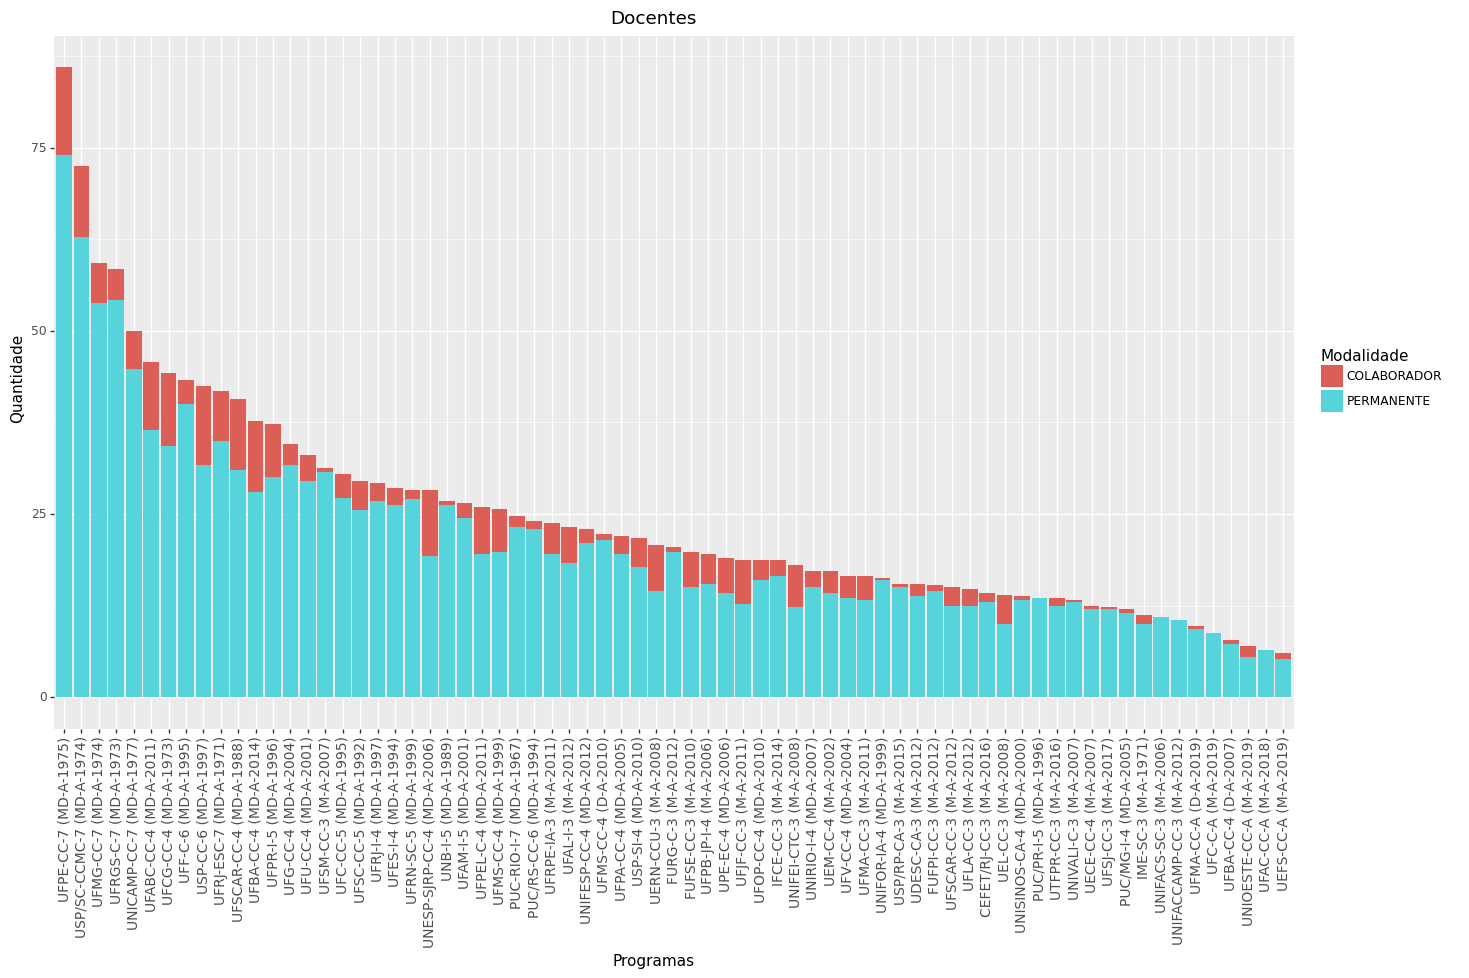

<ggplot: (8763884605665)>

In [88]:
plotDocentes(sumario_docentes, "Docentes")

##Teses

###Teses de doutorado (por ano)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


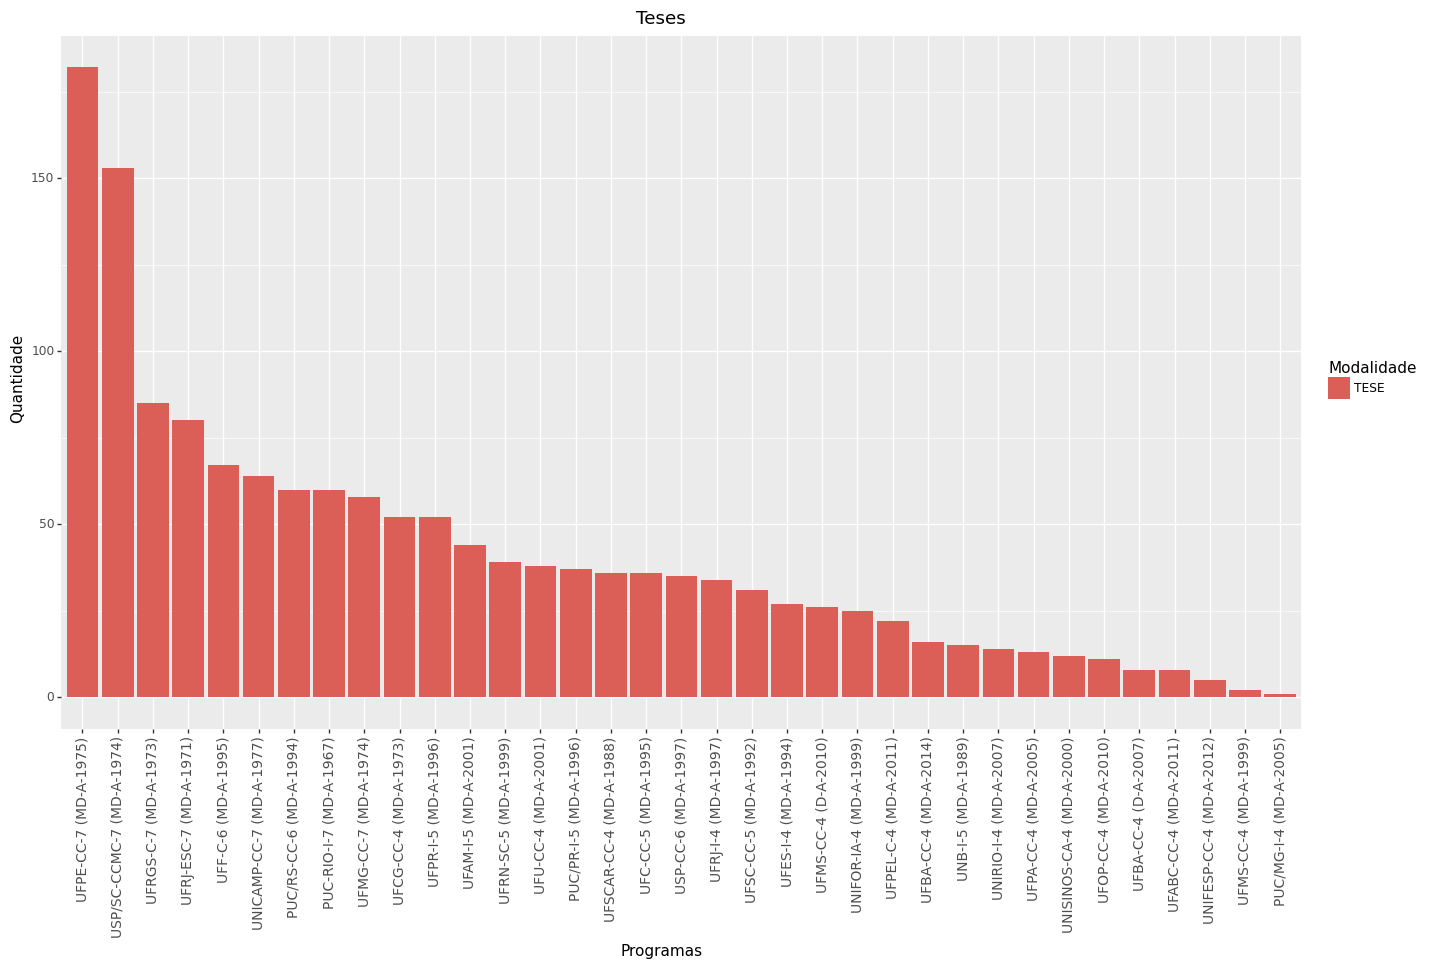

<ggplot: (8763886376417)>

In [89]:
plotTCC(sumario_TCC, "TESE", "Teses")

###Teses de doutorado por docente (por ano)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


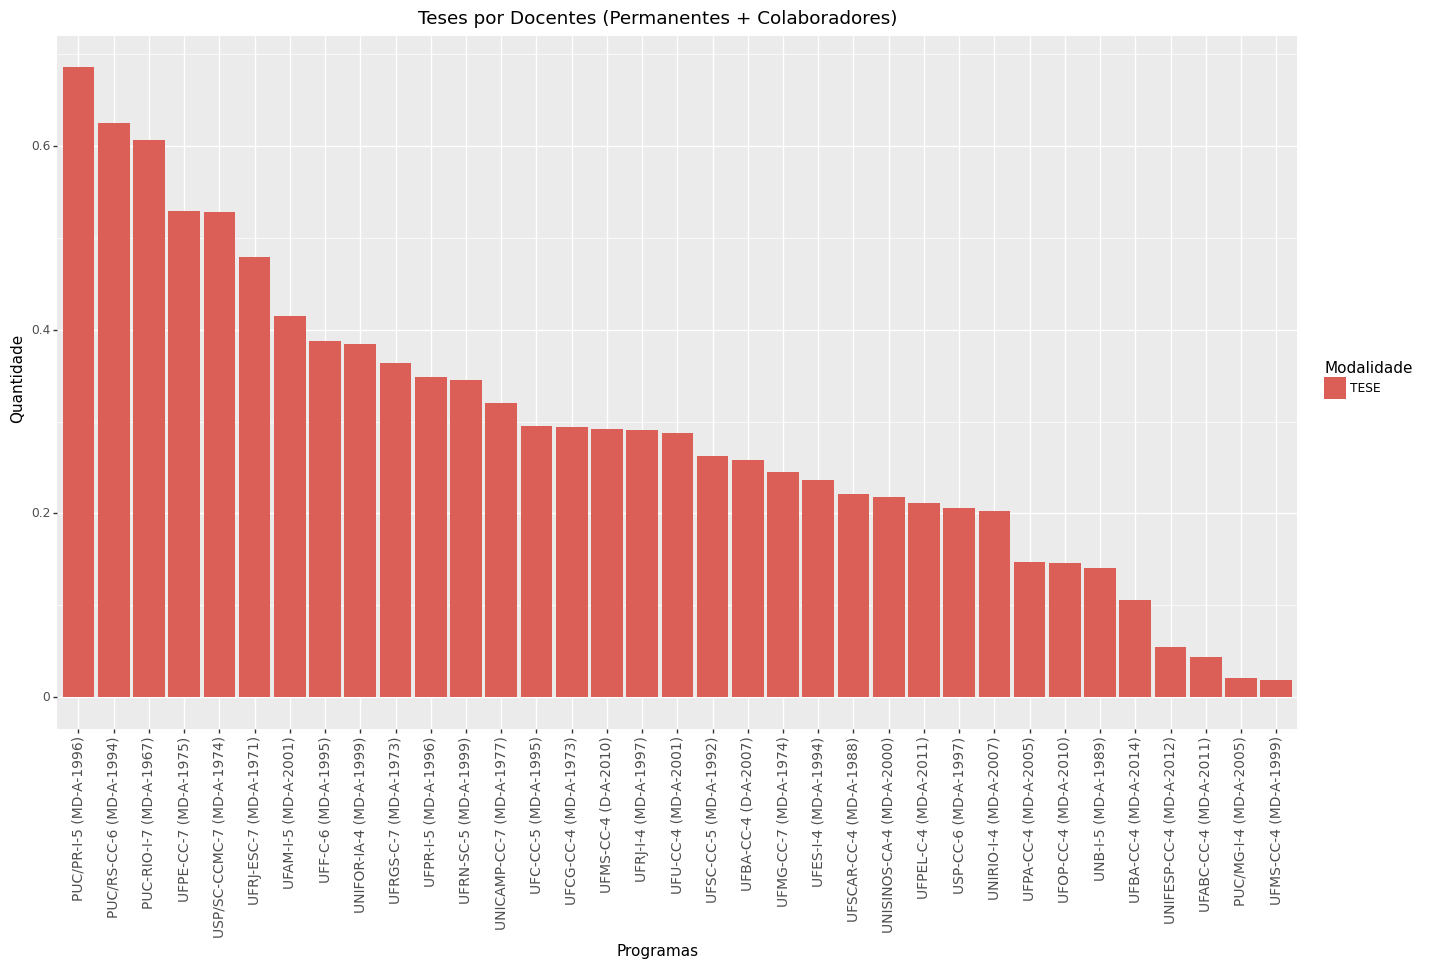

<ggplot: (8763883865337)>

In [90]:
plotTCC(ponderar_por_docs(sumario_TCC, sumario_docentes, ["TESE"]), "TESE", "Teses por Docentes (Permanentes + Colaboradores)")

##Dissertações

###Programas com mestrado – Total de Dissertações defendidas (por ano)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


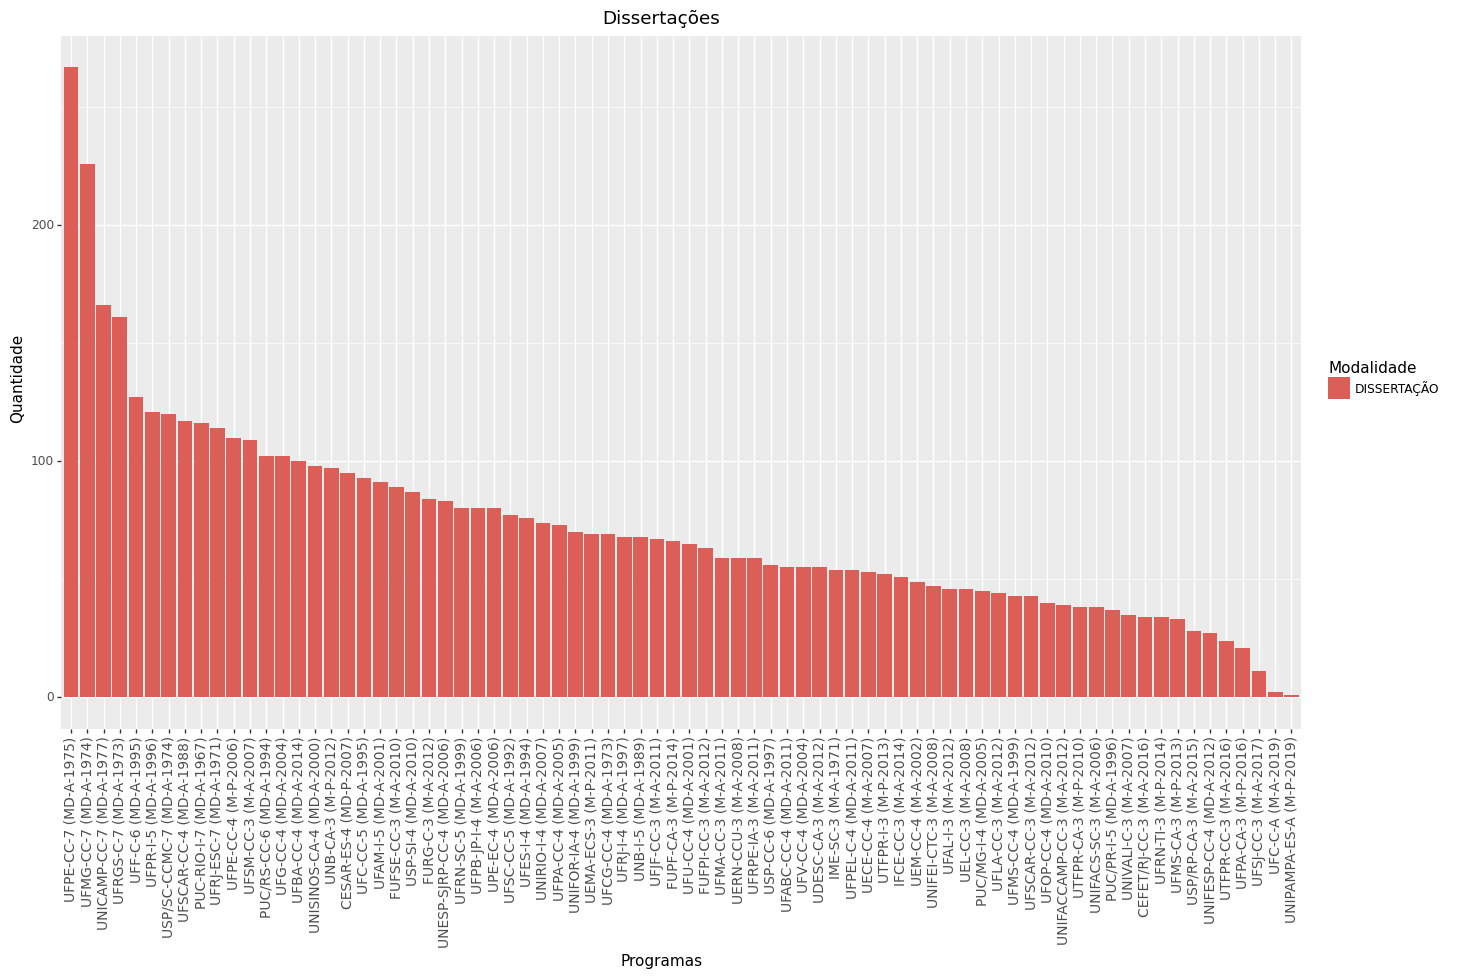

<ggplot: (8763886916829)>

In [91]:
plotTCC(sumario_TCC, "DISSERTAÇÃO", "Dissertações")

###Programas com mestrado – Total de Dissertações defendidas por docente (por ano) <<< conferir

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


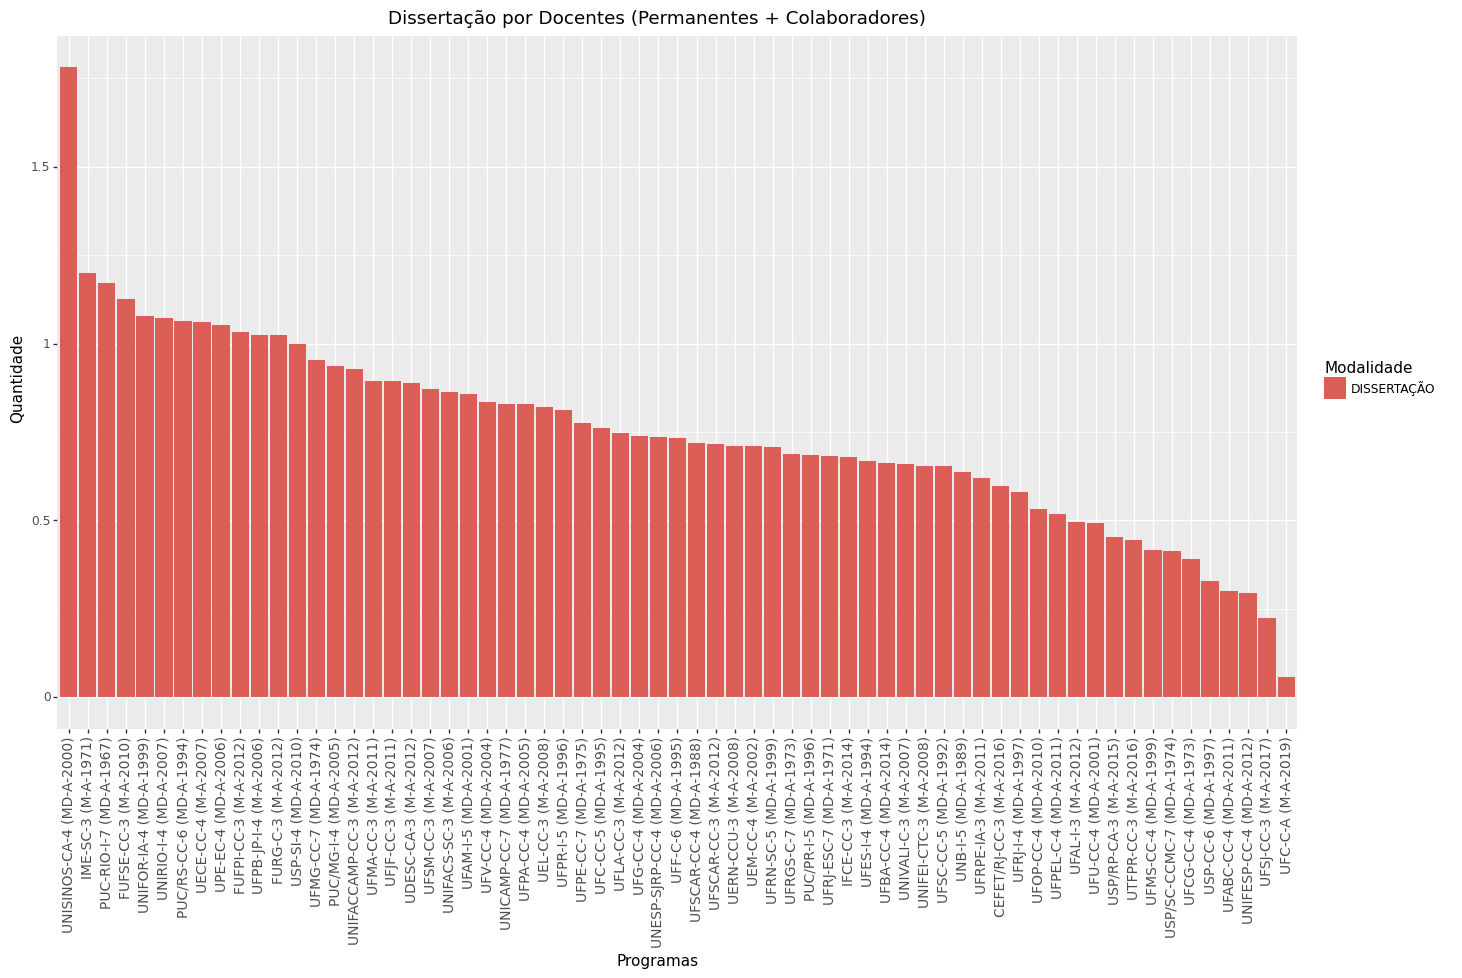

<ggplot: (8763883820397)>

In [92]:
plotTCC(ponderar_por_docs(sumario_TCC, sumario_docentes, ["DISSERTAÇÃO"]), "DISSERTAÇÃO", "Dissertação por Docentes (Permanentes + Colaboradores)")

##Periódicos

###IRestrito em periódicos por docente (por ano)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


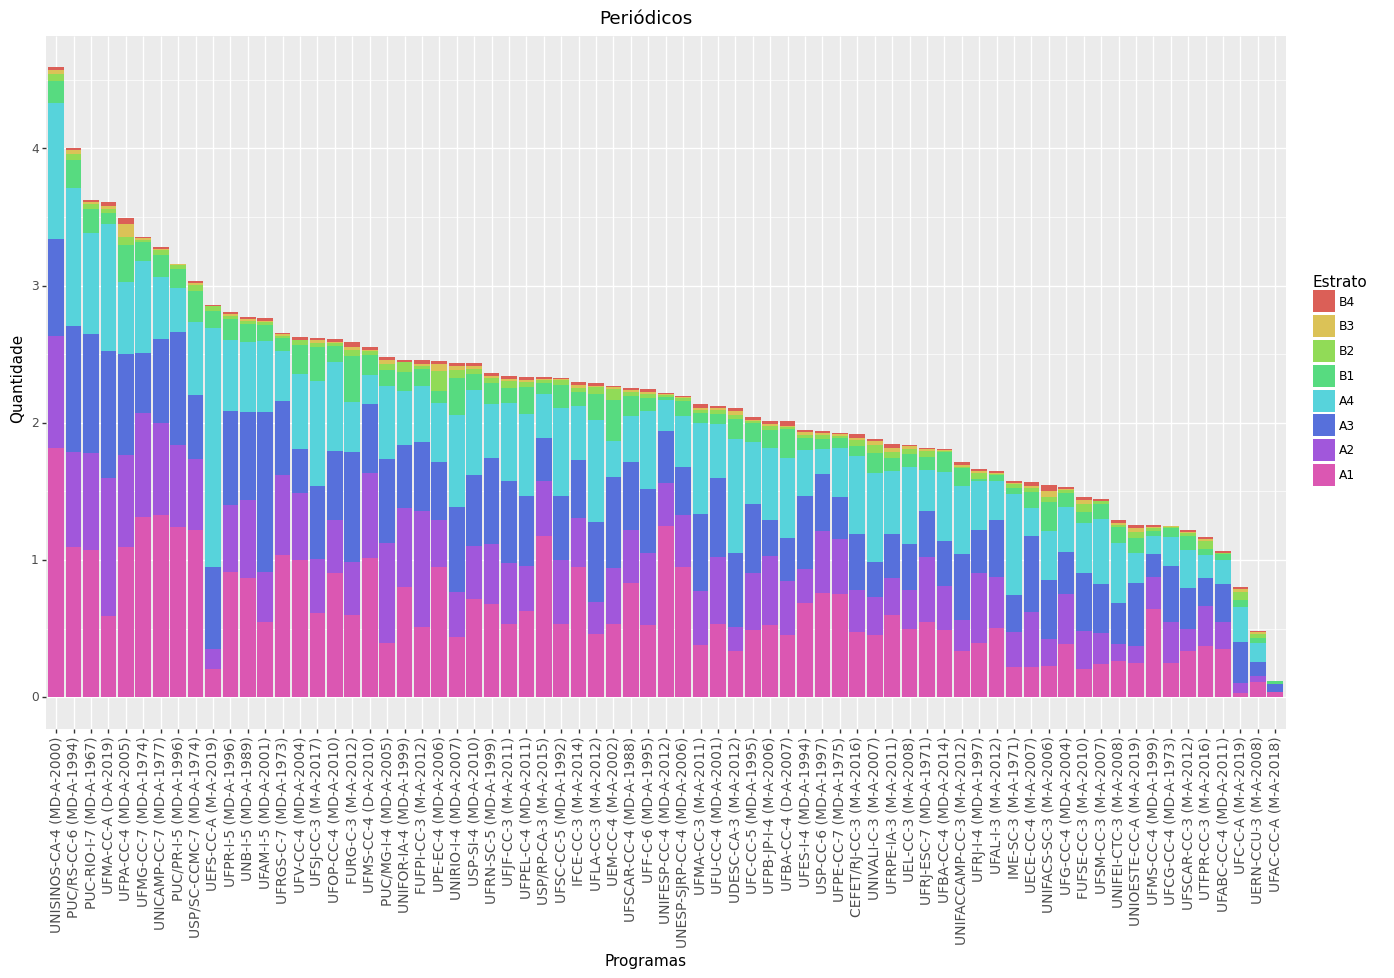

<ggplot: (8763884950769)>

In [93]:
plotPublicacaoQualis(ponderar_por_docs(sumario_prod, sumario_docentes, estratos), "Periódicos", lambda e: e["Qte"] * pesos[e["Estrato"]])

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


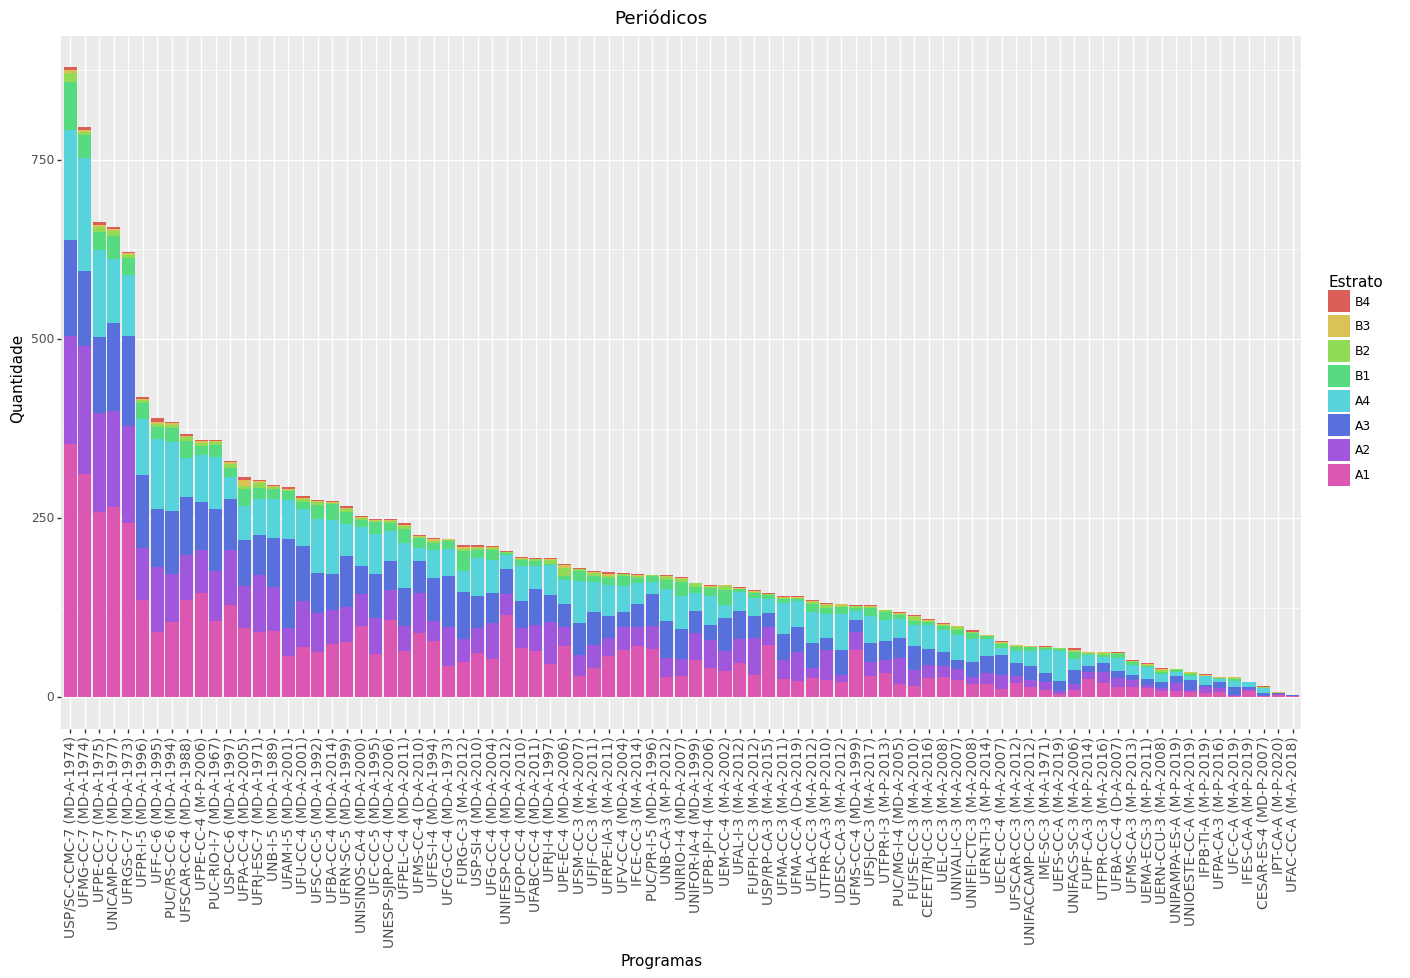

<ggplot: (8763884665085)>

In [94]:
plotPublicacaoQualis(sumario_prod, "Periódicos", lambda e: e["Qte"] * pesos[e["Estrato"]])

###IRestrito em periódicos por docente (por ano) – sem ESWA, JSS, Neurocomputing, Information Sciences

In [95]:
### Todo

### Distribuição interna de periódicos e índice Gini (todos os periódicos)

In [96]:
autores_per = sumario_autores.loc[
  (sumario_autores['Subtipo'].isin(["ARTIGO EM PERIÓDICO"])) & 
  (sumario_autores['Estrato'].isin(estratos)) &
  (sumario_autores['Natureza'] == 'TRABALHO COMPLETO')
]

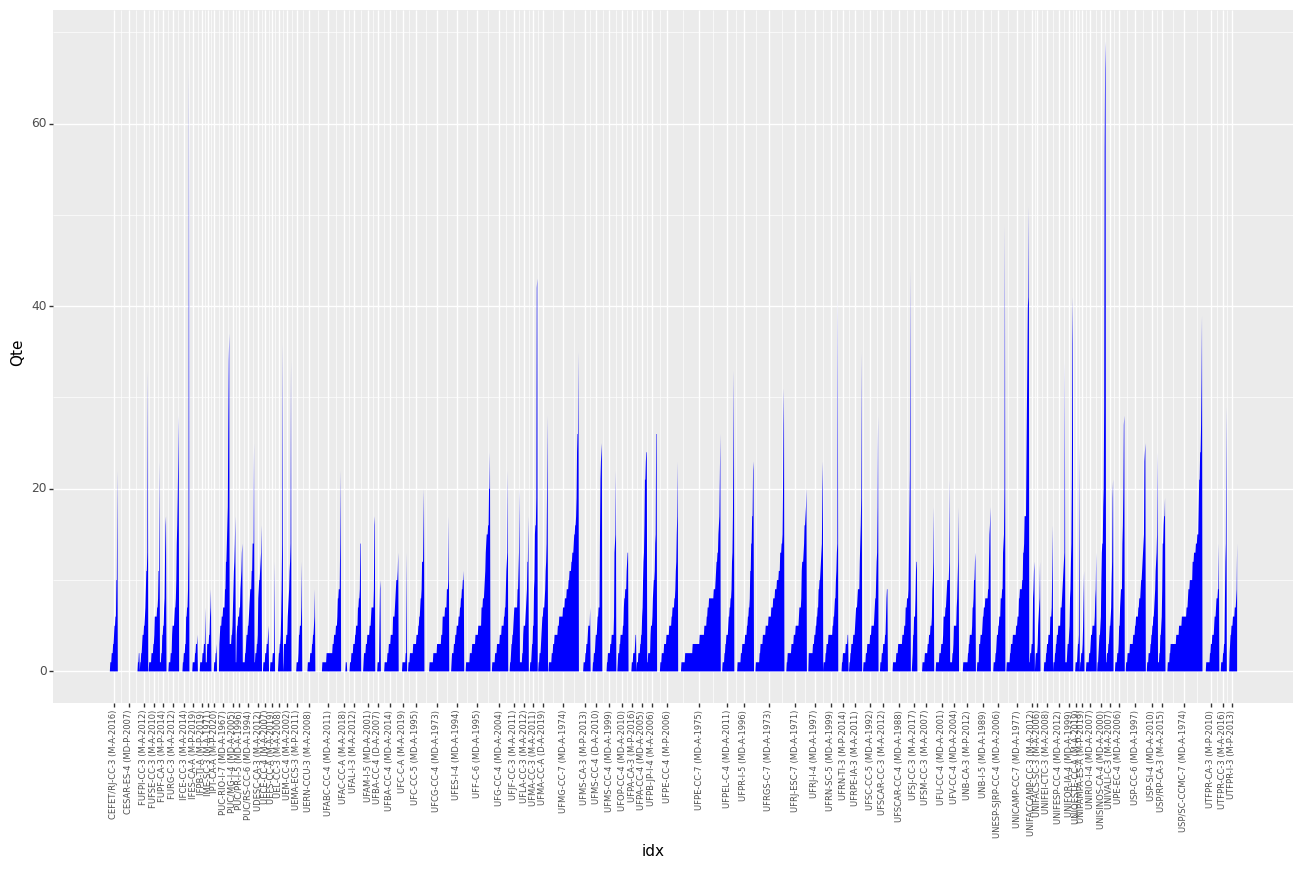

<ggplot: (8763884593461)>

In [97]:
plotCapela(juntar_dados_hist(docentes, autores_per))

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


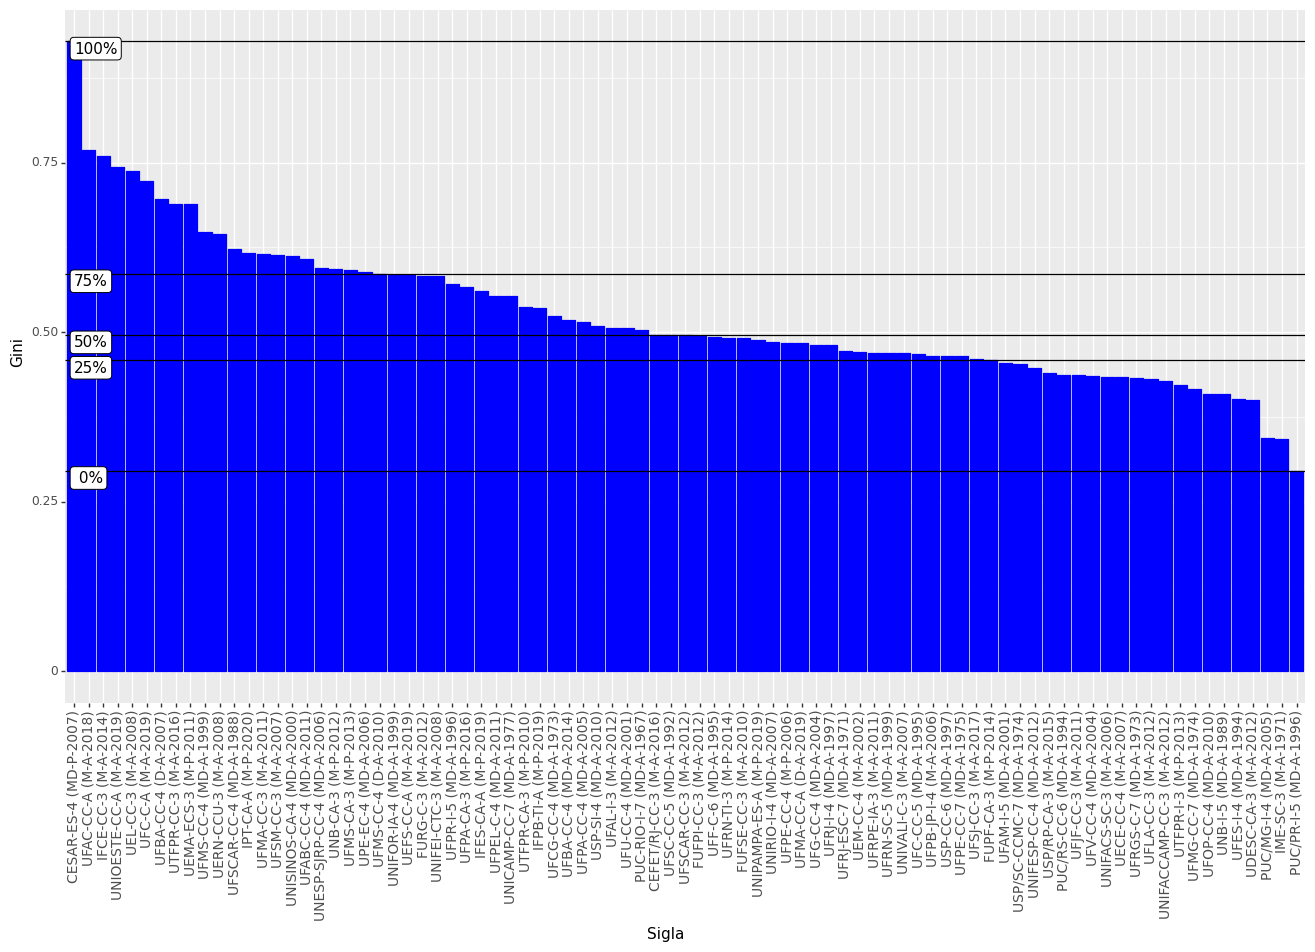

<ggplot: (8763885107113)>

In [98]:
plotHist(juntar_dados_gini(docentes, autores_per), addmedian=True)

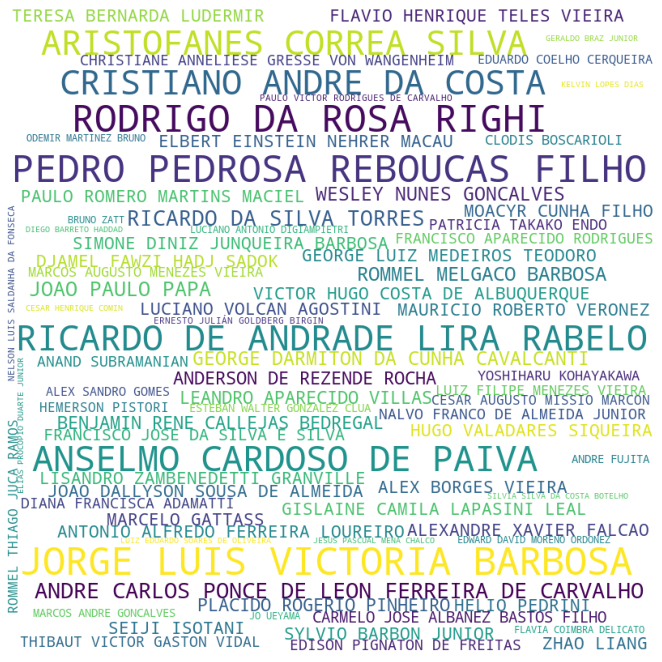

In [99]:
plotNuvemPalavras(sumario_autores.loc[
                              (sumario_autores['Cat'] == 'DOCENTE PERMANENTE') &
                              (sumario_autores['Subtipo'] == 'ARTIGO EM PERIÓDICO') &
                              (sumario_autores['Natureza'] == 'TRABALHO COMPLETO') &
                              (sumario_autores['Estrato'].isin(estratos))
                  ]['Nome do docente'].values)

#Temporario